In [1]:
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cvxopt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


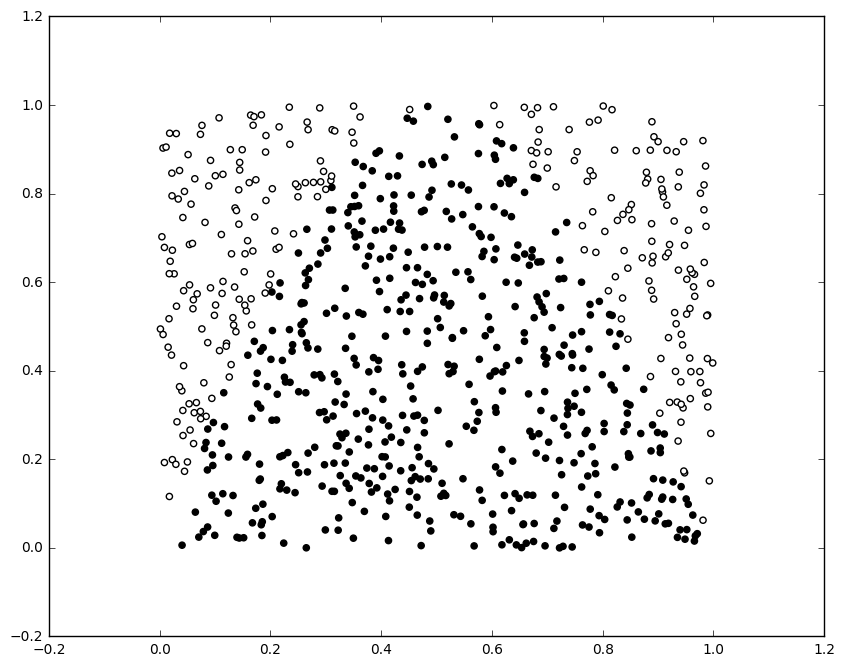

In [2]:
K = 2
N = 400

X = np.random.uniform(size = (N * K, 2))
y = np.sign(X[:, 1] - np.sin(X[:, 0] * np.pi))

train_test_split = np.array(random.sample(range(N * K), N))

X_train = X[train_test_split, :]
y_train = y[train_test_split]
    
X_test = X[-train_test_split, :]
y_test = y[-train_test_split]

plt.scatter(X[:, 0], X[:, 1], c = y);

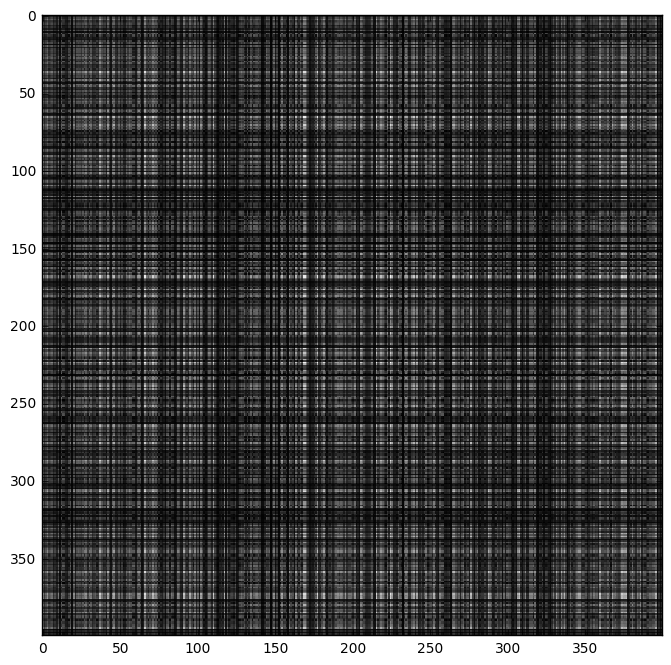

In [3]:
svm_kernel = lambda X, Y: (np.dot(X, Y.T) + 1.0) ** 2

plt.imshow(svm_kernel(X_train, X_train));

     pcost       dcost       gap    pres   dres
 0: -1.6171e+02 -4.2086e+02  1e+03  3e+01  2e+00
 1: -4.3109e+02 -7.4610e+02  7e+02  1e+01  1e+00
 2: -6.7637e+02 -1.0183e+03  7e+02  1e+01  1e+00
 3: -2.3180e+03 -2.7361e+03  8e+02  1e+01  1e+00
 4: -1.4090e+04 -1.4817e+04  1e+03  1e+01  1e+00
 5: -3.8837e+04 -4.0249e+04  2e+03  1e+01  1e+00
 6: -9.8794e+04 -1.0309e+05  5e+03  1e+01  1e+00
 7: -1.4529e+05 -1.5377e+05  1e+04  1e+01  1e+00
 8: -2.8502e+05 -3.1641e+05  3e+04  1e+01  1e+00
 9: -5.3070e+05 -6.2613e+05  1e+05  1e+01  9e-01
10: -9.2374e+05 -1.1561e+06  2e+05  8e+00  7e-01
11: -1.1940e+06 -1.3816e+06  2e+05  3e+00  2e-01
12: -1.2242e+06 -1.2351e+06  1e+04  1e-01  1e-02
13: -1.2246e+06 -1.2248e+06  1e+02  1e-03  1e-04
14: -1.2246e+06 -1.2246e+06  1e+00  1e-05  1e-06
15: -1.2246e+06 -1.2246e+06  1e-02  1e-07  1e-08
16: -1.2246e+06 -1.2246e+06  1e-04  1e-09  3e-09
Optimal solution found.
beta0 = -8.12115301403


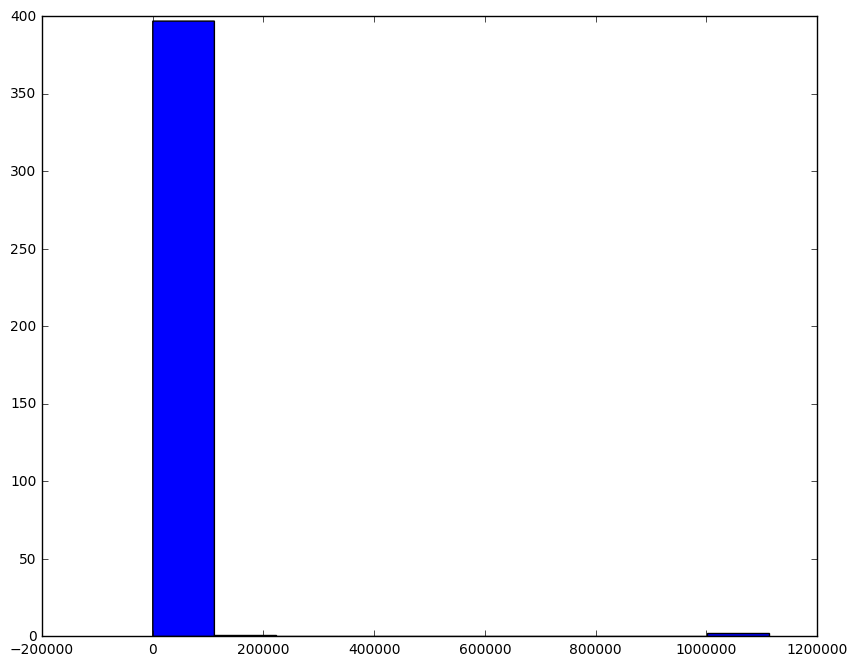

In [4]:
# http://cs229.stanford.edu/notes/cs229-notes3.pdf
# L = sum(alpha) - 1/2 * sum_i(sum_j(alpha_i * alpha_j * y_i * y_j * kernel(x_i, x_j)))
# subject to sum_i(alpha_i * y_i) = 0
#            alpha > 0

# http://cvxopt.org/userguide/coneprog.html#quadratic-programming
# minimize 1/2 * x.T * P * x + q.T * x
# subject to G * x < h
#            A * x = b

def svm_train(X, y):
    N = X.shape[0]

    P = cvxopt.matrix(svm_kernel(X, X) * np.outer(y, y))
    q = cvxopt.matrix(-np.ones(N))
    G = cvxopt.matrix(-1.0 * np.eye(N))
    h = cvxopt.matrix(0.0, (N, 1))
    A = cvxopt.matrix(y, (1, N))
    b = cvxopt.matrix(0.0)

    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    
    alpha = np.array(solution["x"]).reshape(-1)
    
    beta = np.sum(alpha * y * svm_kernel(X, X).T, axis = 1)
    beta0 = -(np.max(beta[y > 0]) + np.min(beta[y < 0])) / 2.
    
    return (alpha, beta0)

(alpha, beta0) = svm_train(X_train, y_train)

print("beta0 =", beta0)
plt.hist(alpha);

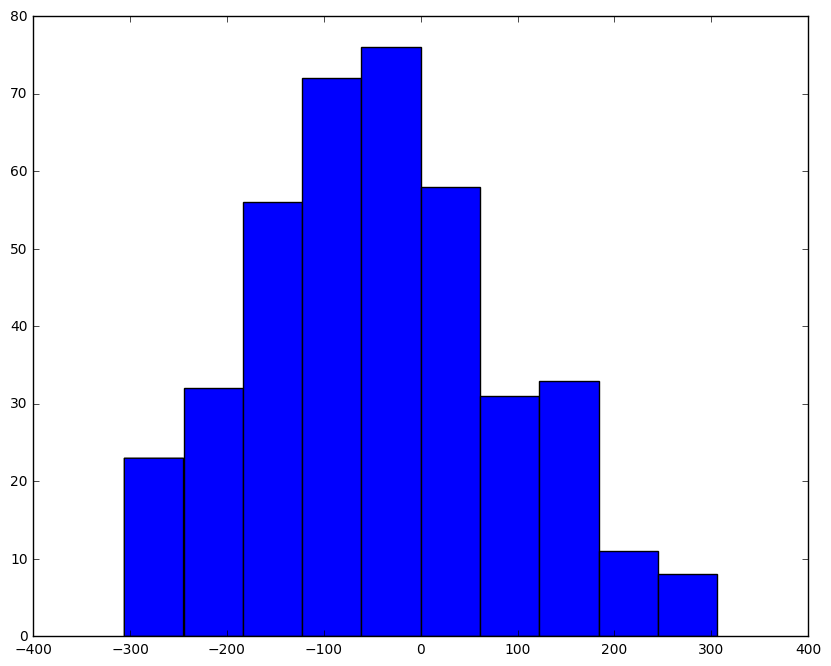

In [5]:
plt.hist(np.sum(alpha * y_train * svm_kernel(X_train, X_train).T, axis = 1) + beta0);

In [6]:
def svm_transform(X): return np.sum(alpha * y_train * svm_kernel(X_train, X).T, axis = 1) + beta0
def svm_predict(X):  return np.sign(svm_transform(X))

print("accuracy on training set =", (svm_predict(X_train) == y_train).mean())
print("accuracy on test set =", (svm_predict(X_test) == y_test).mean())


accuracy on training set = 0.965
accuracy on test set = 0.96


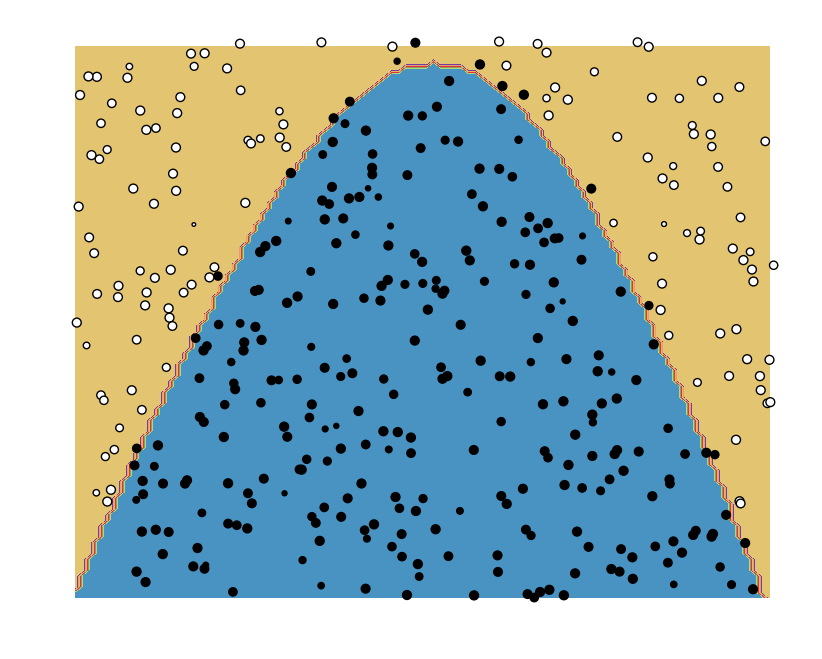

In [7]:
xx, yy = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
X_boundary = np.c_[xx.ravel(), yy.ravel()]
y_transform = svm_transform(X_boundary)
y_predict = svm_predict(X_boundary)

plt.contourf(xx, yy, y_predict.reshape(xx.shape), cmap=plt.cm.Paired)
plt.axis('off')
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, s = 5 * np.log2(2 + np.abs(y_transform)));

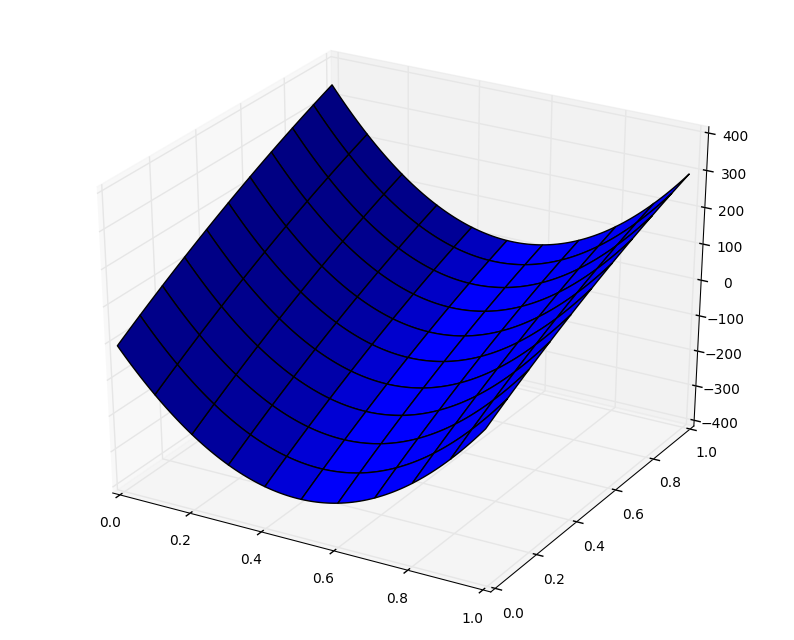

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, y_transform.reshape(xx.shape), color='b');

In [9]:
mnist = pickle.Unpickler(open('mnist.pkl', 'rb'), encoding = 'latin1').load()

(train, validation, test) = mnist
(train_images, train_labels) = train
(validation_images, validation_labels) = validation
(test_images, test_labels) = test

print(train_images.shape)
print(train_labels.shape)
print(validation_images.shape)
print(test_images.shape)

(50000, 784)
(50000,)
(10000, 784)
(10000, 784)


In [11]:
%%time
N = 10000

y_pred_sum = np.zeros(N)

for i in range(5):
    i1 = i * N
    i2 = (i + 1) * N

    X_train = train_images[i1 : i2, :]
    y_train = 2. * (train_labels[i1 : i2] >= 5) - 1.

    (alpha, beta0) = svm_train(X_train, y_train)

    print("accuracy on training set =", (svm_predict(X_train) == y_train).mean())

    y_pred = svm_predict(test_images)
    print("accuracy on test set =", (y_pred == 2. * (test_labels >= 5) - 1.).mean())
    
    y_pred_sum += y_pred

     pcost       dcost       gap    pres   dres
 0: -2.9082e+00 -8.6599e+00  1e+04  1e+02  1e+00
 1: -5.0298e-01 -1.1010e+01  4e+02  4e+00  4e-02
 2: -1.6793e+00 -6.9633e+00  1e+02  9e-01  9e-03
 3: -1.7814e+00 -3.7330e+00  3e+01  2e-01  2e-03
 4: -1.3569e+00 -2.0476e+00  8e+00  6e-02  6e-04
 5: -9.8956e-01 -1.3108e+00  3e+00  2e-02  2e-04
 6: -7.7858e-01 -1.0041e+00  1e+00  7e-03  7e-05
 7: -6.8304e-01 -8.3668e-01  5e-01  2e-03  2e-05
 8: -6.8143e-01 -7.5056e-01  2e-01  6e-04  6e-06
 9: -6.9201e-01 -7.2037e-01  4e-02  7e-05  7e-07
10: -7.0518e-01 -7.1271e-01  8e-03  3e-06  3e-08
11: -7.0989e-01 -7.1115e-01  1e-03  2e-07  2e-09
12: -7.1085e-01 -7.1090e-01  5e-05  5e-09  5e-11
13: -7.1089e-01 -7.1089e-01  9e-07  7e-11  8e-13
14: -7.1089e-01 -7.1089e-01  2e-08  1e-12  2e-13
Optimal solution found.
accuracy on training set = 0.802
accuracy on test set = 0.802
     pcost       dcost       gap    pres   dres
 0: -2.9196e+00 -8.7031e+00  1e+04  1e+02  1e+00
 1: -5.2783e-01 -1.1052e+01  5e+02

In [12]:
print("ensemble accuracy on test set =", (np.sign(y_pred_sum) == 2. * (test_labels >= 5) - 1.).mean())

ensemble accuracy on test set = 0.9439
